In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [6]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [7]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

 Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) to see a list of available feature vectors. Click on the `tf2-preview/mobilenet_v2/feature_vector`. Read the documentation and get the corresponding `URL` to get the MobileNet v2 feature vector. Finally, create a `feature_extractor` by using `hub.KerasLayer` with the correct `input_shape` parameter.

In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [9]:
feature_extractor.trainable = False

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 4s 51ms/step - loss: 0.7321 - accuracy: 0.7361 - val_loss: 0.4370 - val_accuracy: 0.8656
Epoch 2/6
81/81 [==============================] - 4s 45ms/step - loss: 0.3685 - accuracy: 0.8832 - val_loss: 0.3542 - val_accuracy: 0.8901
Epoch 3/6
81/81 [==============================] - 4s 45ms/step - loss: 0.2901 - accuracy: 0.9093 - val_loss: 0.3144 - val_accuracy: 0.9001
Epoch 4/6
81/81 [==============================] - 4s 45ms/step - loss: 0.2462 - accuracy: 0.9245 - val_loss: 0.2977 - val_accuracy: 0.9037
Epoch 5/6
81/81 [==============================] - 4s 45ms/step - loss: 0.2068 - accuracy: 0.9420 - val_loss: 0.3204 - val_accuracy: 0.8928
Epoch 6/6
81/81 [==============================] - 4s 45ms/step - loss: 0.1854 - accuracy: 0.9482 - val_loss: 0.2813 - val_accuracy: 0.9074


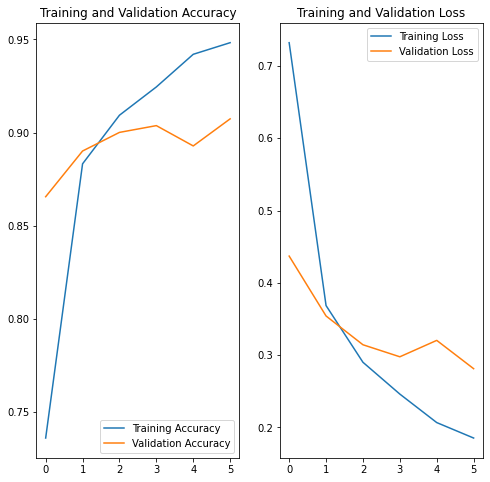

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [14]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['daisy' 'tulips' 'daisy' 'dandelion' 'daisy' 'dandelion' 'dandelion'
 'sunflowers' 'sunflowers' 'tulips' 'tulips' 'tulips' 'sunflowers'
 'dandelion' 'tulips' 'roses' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'roses' 'tulips' 'dandelion' 'daisy' 'sunflowers' 'tulips'
 'sunflowers' 'sunflowers' 'roses' 'roses' 'dandelion' 'tulips']


In [15]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [1 2 1 0 1 0 0 3 3 2 2 2 3 0 2 4 0 0 0 0 4 2 0 1 3 2 3 3 4 4 0 2]
Predicted labels:  [1 2 1 0 1 0 0 3 3 2 2 2 3 0 2 4 0 0 0 0 4 2 0 1 3 2 3 3 4 4 0 2]


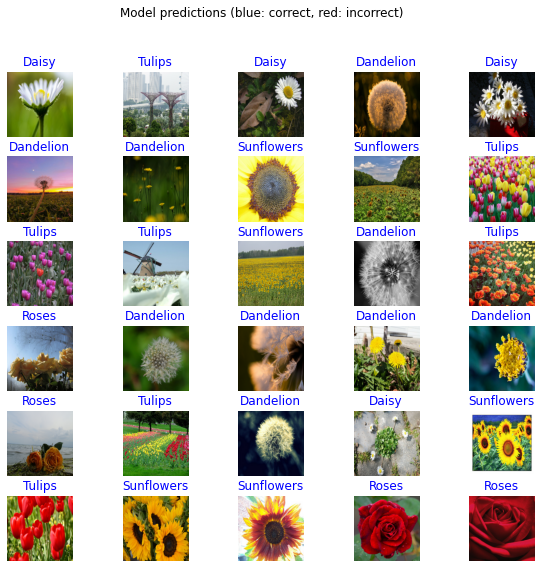

In [16]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [17]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

In [18]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 10s 125ms/step - loss: 0.7431 - accuracy: 0.7299 - val_loss: 0.4414 - val_accuracy: 0.8629
Epoch 2/6
81/81 [==============================] - 8s 103ms/step - loss: 0.3907 - accuracy: 0.8786 - val_loss: 0.3661 - val_accuracy: 0.8847
Epoch 3/6
81/81 [==============================] - 8s 102ms/step - loss: 0.3096 - accuracy: 0.9000 - val_loss: 0.3745 - val_accuracy: 0.8610
Epoch 4/6
81/81 [==============================] - 8s 103ms/step - loss: 0.2720 - accuracy: 0.9116 - val_loss: 0.2998 - val_accuracy: 0.8983
Epoch 5/6
81/81 [==============================] - 8s 103ms/step - loss: 0.2342 - accuracy: 0.9272 - val_loss: 0.2875 - val_accuracy: 0.8992
Epoch 6/6
81/81 [==============================] - 8s 102ms/step - loss: 0.2072 - accuracy: 0.9373 - val_loss: 0.2912 - val_accuracy: 0.8955
